---

## Setup

Run the following 5 cells in order to set up needed functions. Don't worry about the code for now!

In [3]:
# # @title Install requirements
# from IPython.display import clear_output
# # @markdown we install the acme library, see [here](https://github.com/deepmind/acme) for more info

# # @markdown WARNING: There may be errors and warnings reported during the installation.
# # @markdown However, they should be ignored.
# !apt-get install -y xvfb ffmpeg --quiet
# !pip install --upgrade pip --quiet
# !pip install imageio --quiet
# !pip install imageio-ffmpeg
# !pip install gym --quiet
# !pip install enum34 --quiet
# !pip install dm-env --quiet
# !pip install pandas --quiet
# !pip install keras-nightly==2.5.0.dev2021020510 --quiet
# !pip install grpcio==1.34.0 --quiet
# !pip install tensorflow --quiet
# !pip install typing --quiet
# !pip install einops --quiet
# !pip install dm-acme --quiet
# !pip install dm-acme[reverb] --quiet
# !pip install dm-acme[tf] --quiet
# !pip install dm-acme[envs] --quiet
# !pip install dm-env --quiet

# clear_output()

In [1]:
# Import modules
import gym
import enum
import copy
import time
import acme
import torch
import base64
import dm_env
import IPython
import imageio
import warnings
import itertools
import collections

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib as mpl
import matplotlib.pyplot as plt

import tensorflow.compat.v2 as tf

from acme import specs
from acme import wrappers
from acme.utils import tree_utils
from acme.utils import loggers
from torch.autograd import Variable
from torch.distributions import Categorical
from typing import Callable, Sequence

tf.enable_v2_behavior()
warnings.filterwarnings('ignore')
np.set_printoptions(precision=3, suppress=1)

In [ ]:
# brief import
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np

## Helper functions

In [2]:
# @title Figure settings
import ipywidgets as widgets       # interactive display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")
mpl.rc('image', cmap='Blues')

In [4]:
# @title Helper Functions
# @markdown Implement helpers for value visualisation

map_from_action_to_subplot = lambda a: (2, 6, 8, 4)[a]
map_from_action_to_name = lambda a: ("up", "right", "down", "left")[a]


def plot_values(values, colormap='pink', vmin=-1, vmax=10):
  plt.imshow(values, interpolation="nearest",
             cmap=colormap, vmin=vmin, vmax=vmax)
  plt.yticks([])
  plt.xticks([])
  plt.colorbar(ticks=[vmin, vmax])


def plot_state_value(action_values, epsilon=0.1):
  q = action_values
  fig = plt.figure(figsize=(4, 4))
  vmin = np.min(action_values)
  vmax = np.max(action_values)
  v = (1 - epsilon) * np.max(q, axis=-1) + epsilon * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")


def plot_action_values(action_values, epsilon=0.1):
  q = action_values
  fig = plt.figure(figsize=(8, 8))
  fig.subplots_adjust(wspace=0.3, hspace=0.3)
  vmin = np.min(action_values)
  vmax = np.max(action_values)
  dif = vmax - vmin
  for a in [0, 1, 2, 3]:
    plt.subplot(3, 3, map_from_action_to_subplot(a))

    plot_values(q[..., a], vmin=vmin - 0.05*dif, vmax=vmax + 0.05*dif)
    action_name = map_from_action_to_name(a)
    plt.title(r"$q(s, \mathrm{" + action_name + r"})$")

  plt.subplot(3, 3, 5)
  v = (1 - epsilon) * np.max(q, axis=-1) + epsilon * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")


def plot_stats(stats, window=10):
  plt.figure(figsize=(16,4))
  plt.subplot(121)
  xline = range(0, len(stats.episode_lengths), window)
  plt.plot(xline, smooth(stats.episode_lengths, window=window))
  plt.ylabel('Episode Length')
  plt.xlabel('Episode Count')
  plt.subplot(122)
  plt.plot(xline, smooth(stats.episode_rewards, window=window))
  plt.ylabel('Episode Return')
  plt.xlabel('Episode Count')

In [5]:
# @title Helper functions
def smooth(x, window=10):
  return x[:window*(len(x)//window)].reshape(len(x)//window, window).mean(axis=1)

## Set random seed, device

In [6]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# for DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [7]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# inform the user if the notebook uses GPU or CPU.

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [8]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.
GPU is enabled in this notebook.


## Binary Maze

Generating a 15x15 Maze


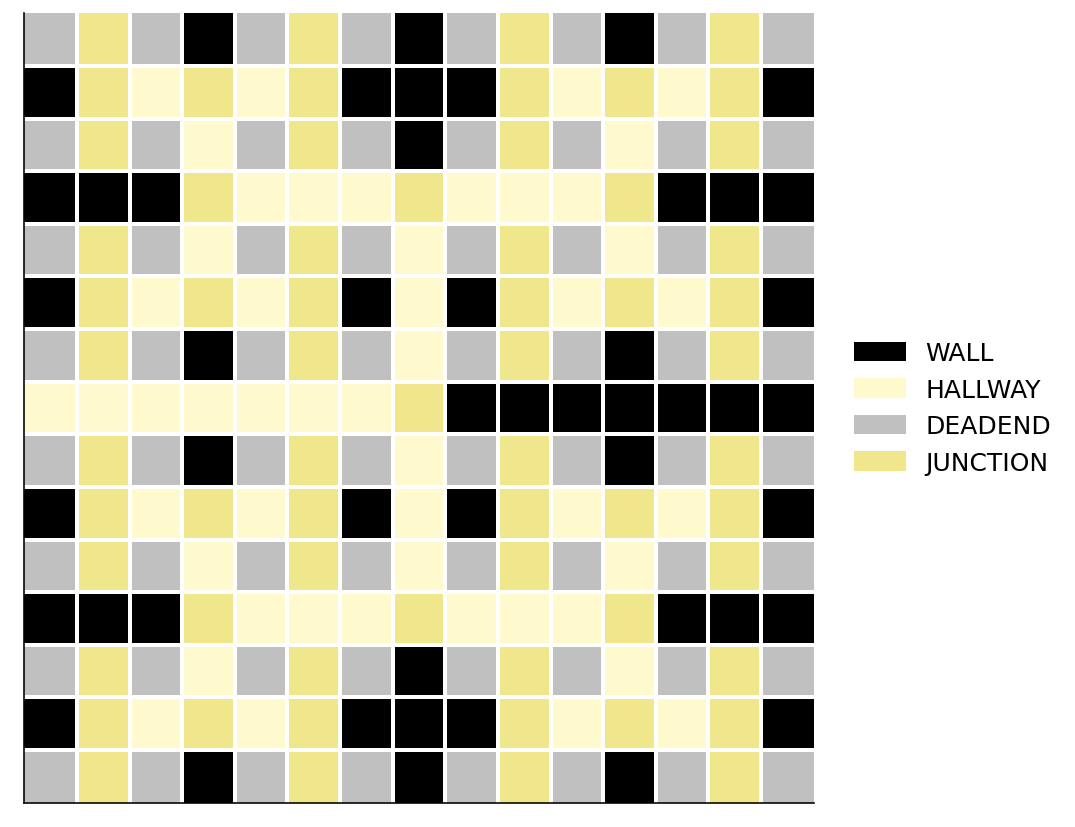

In [9]:
from matplotlib import colors
import matplotlib.patches as mpatches

class Features(enum.IntEnum):
  WALL = 0
  HALLWAY = enum.auto()
  DEADEND = enum.auto()
  JUNCTION = enum.auto()

class BinMaze:
  '''
  Binary maze defined by the number of maximum level of bifurcations/junctions
  '''
  def __init__( self, mlevel: "(Exponential) Levels of bifurcations"):
    # Set maximum level of bifurfaction \in [0, mlevel]
    self.mlevel = mlevel

  @property
  def pose(self):
    return self._pose

  @property
  def mlevel(self):
    return self._mlevel

  @mlevel.setter
  def mlevel(self, val: int):
    self._mlevel = val
    # Length of half the maze; excluding the hallway
    hcols = 2**(self._mlevel//2) - 1
    # Odd (Even) number of bifurcations: Rectangular (Square) maze
    hrows = 2**(self._mlevel//2 + self._mlevel%2) - 1
    # Initialize Maze space
    oddify = lambda x: 2*x+1
    self.features = np.zeros( [ oddify(hrows), oddify(hcols) ] )
    print(f"Generating a {self.features.shape[0]}x{self.features.shape[1]} Maze")

    # Start state: Label as hallway
    self._entry = np.array( [ hrows, 0 ] )
    self.features[ tuple(self._entry) ] = Features.HALLWAY
    # Starting pose of the agent
    self._pose = np.array([1,0])
    # First junction: Label
    self._first_junction = np.array( [ hrows, hcols ] )
    self.features[ tuple(self._first_junction) ] = Features.JUNCTION
    # Label the entry Hallway
    self.hallIndex( self._entry, self._first_junction )
    # Recursive build starting from the first junction
    self.build( self._first_junction, self._mlevel-1, self._pose )
    # Cosmetic change to keep visual consistency
    self.features = self.features.T[::-1,:] if self._mlevel%2 else self.features
    # Switch pose to match alignment
    self._pose = np.flip(self._pose) if self._mlevel%2 else self._pose
    self.get_layout()

  def get_layout(self):
    '''
      Returns layout compatible with Gridworld
      -1 for inaccessible; 0 for all accessible states
    '''
    self.layout = -1 * np.ones_like(self.features)
    self.layout[self.features > 0] = 0

  def hallIndex(  self, a: "Starting junction index, np.array([int, int])",
                  b: "Ending index, np.array([int, int])"):
    '''Set the states between state a and b as hallways (non-exclusive)'''
    incr = b - a
    # Number of hallway states: assumes grid-world with 90 deg turns
    nh = abs( incr[incr!=0][0] )
    ind = np.array( [ a + np.sign(incr) * x for x in range(1,nh) ] )
    if ind.size:
      self.features[ ind[:,0], ind[:,1] ] = Features.HALLWAY

  def build(  self, _start: "Starting location, np.array([int, int])",
                    level: "level of recusrsion, int \in [0,self._mlevel]",
                    bivec: "Bifurcation vector for 90 deg turns"  ):
    '''Recursive top-down build of the maze'''
    if level < 0:
      return
    # Length of level-dependent hallway
    lhw =  (2**(level//2) ) * bivec
    _r = _start + lhw
    # Add states to hallways
    self.hallIndex(_start, _r)
    _l = _start - lhw
    self.hallIndex(_start, _l)
    # Label junction and deadend features
    self.features[tuple(_r)] = self.features[tuple(_l)] = \
      Features.DEADEND if level == 0 else Features.JUNCTION
    # Recursive calls to lower levels
    self.build( _l, level-1, np.flip(bivec) )
    self.build( _r, level-1, np.flip(bivec) )

  def plot_grid(self):
    imap = {  Features.WALL.value: "k", Features.HALLWAY.value: "lemonchiffon",
              Features.JUNCTION.value: "khaki", Features.DEADEND.value: "silver" }
    iarr = np.array(list(imap.items()))
    iarr = iarr[iarr[:,0].argsort(), :]
    # Create discrete colormap
    cmap = colors.ListedColormap(iarr[:,1])
    bounds = list(iarr[:,0].astype(int)*10 )
    bounds += [bounds[-1]+10]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    # Init fig object
    fig, ax = plt.subplots()
    ax.imshow(self.features*10, cmap=cmap, norm=norm)
    # Add cell demarcators
    h, w = self.features.shape
    for y in range(h - 1):
      plt.plot([-0.5, w - 0.5], [y + 0.5, y + 0.5], '-w', lw=2)
    for x in range(w - 1):
      plt.plot([x + 0.5, x + 0.5], [-0.5, h - 0.5], '-w', lw=2)
    ax.grid(0)
    plt.xticks([])
    plt.yticks([])
    # Add a legend
    patches = []
    for key, col in iarr:
      _patch = mpatches.Patch(color=col, label=Features(int(key)).name)
      patches.append(_patch)
    ax.legend(  handles=patches, frameon=False,
                bbox_to_anchor=(1.04,0.5), loc="center left",
                borderaxespad=0)
    plt.show()


M = BinMaze(6)
M.plot_grid()

## Set up gridworld; Acme: a research framework for reinforcement learning

**Acme** is a library of reinforcement learning (RL) agents and agent building blocks by Google DeepMind. Acme strives to expose simple, efficient, and readable agents, that serve both as reference implementations of popular algorithms and as strong baselines, while still providing enough flexibility to do novel research. The design of Acme also attempts to provide multiple points of entry to the RL problem at differing levels of complexity.

For more information see [github repository](https://github.com/deepmind/acme).

In [10]:
# @title Implement GridWorld { form-width: "30%" }
# @markdown *Double-click* to inspect the contents of this cell.

class ObservationType(enum.IntEnum):
  STATE_INDEX = enum.auto()
  AGENT_ONEHOT = enum.auto()
  GRID = enum.auto()
  AGENT_GOAL_POS = enum.auto()


class GridWorld(dm_env.Environment):

  def __init__(self,
               layout,
               start_state,
               goal_state=None,
               observation_type=ObservationType.STATE_INDEX,
               discount=0.9,
               penalty_for_walls=-5,
               reward_goal=10,
               max_episode_length=None,
               randomize_goals=False):
    """Build a grid environment.

    Simple gridworld defined by a map layout, a start and a goal state.

    Layout should be a NxN grid, containing:
      * 0: empty
      * -1: wall
      * Any other positive value: value indicates reward; episode will terminate

    Args:
      layout: NxN array of numbers, indicating the layout of the environment.
      start_state: Tuple (y, x) of starting location.
      goal_state: Optional tuple (y, x) of goal location. Will be randomly
        sampled once if None.
      observation_type: Enum observation type to use. One of:
        * ObservationType.STATE_INDEX: int32 index of agent occupied tile.
        * ObservationType.AGENT_ONEHOT: NxN float32 grid, with a 1 where the
          agent is and 0 elsewhere.
        * ObservationType.GRID: NxNx3 float32 grid of feature channels.
          First channel contains walls (1 if wall, 0 otherwise), second the
          agent position (1 if agent, 0 otherwise) and third goal position
          (1 if goal, 0 otherwise)
        * ObservationType.AGENT_GOAL_POS: float32 tuple with
          (agent_y, agent_x, goal_y, goal_x)
      discount: Discounting factor included in all Timesteps.
      penalty_for_walls: Reward added when hitting a wall (should be negative).
      reward_goal: Reward added when finding the goal (should be positive).
      max_episode_length: If set, will terminate an episode after this many
        steps.
      randomize_goals: If true, randomize goal at every episode.
    """
    if observation_type not in ObservationType:
      raise ValueError('observation_type should be a ObservationType instace.')
    self._layout = np.array(layout)
    self._start_state = start_state
    self._state = self._start_state
    self._number_of_states = np.prod(np.shape(self._layout))
    self._discount = discount
    self._penalty_for_walls = penalty_for_walls
    self._reward_goal = reward_goal
    self._observation_type = observation_type
    self._layout_dims = self._layout.shape
    self._max_episode_length = max_episode_length
    self._num_episode_steps = 0
    self._randomize_goals = randomize_goals
    if goal_state is None:
      # Randomly sample goal_state if not provided
      goal_state = self._sample_goal()
    self.goal_state = goal_state

  def _sample_goal(self):
    """Randomly sample reachable non-starting state."""
    # Sample a new goal
    n = 0
    max_tries = 1e5
    while n < max_tries:
      goal_state = tuple(np.random.randint(d) for d in self._layout_dims)
      if goal_state != self._state and self._layout[goal_state] == 0:
        # Reachable state found!
        return goal_state
      n += 1
    raise ValueError('Failed to sample a goal state.')

  @property
  def layout(self):
    return self._layout

  @property
  def number_of_states(self):
    return self._number_of_states

  @property
  def goal_state(self):
    return self._goal_state

  @property
  def start_state(self):
    return self._start_state

  @property
  def state(self):
    return self._state

  def set_state(self, x, y):
    self._state = (y, x)

  @goal_state.setter
  def goal_state(self, new_goal):
    if new_goal == self._state or self._layout[new_goal] < 0:
      raise ValueError('This is not a valid goal!')
    # Zero out any other goal
    self._layout[self._layout > 0] = 0
    # Setup new goal location
    self._layout[new_goal] = self._reward_goal
    self._goal_state = new_goal

  def observation_spec(self):
    if self._observation_type is ObservationType.AGENT_ONEHOT:
      return specs.Array(
          shape=self._layout_dims,
          dtype=np.float32,
          name='observation_agent_onehot')
    elif self._observation_type is ObservationType.GRID:
      return specs.Array(
          shape=self._layout_dims + (3,),
          dtype=np.float32,
          name='observation_grid')
    elif self._observation_type is ObservationType.AGENT_GOAL_POS:
      return specs.Array(
          shape=(4,), dtype=np.float32, name='observation_agent_goal_pos')
    elif self._observation_type is ObservationType.STATE_INDEX:
      return specs.DiscreteArray(
          self._number_of_states, dtype=int, name='observation_state_index')

  def action_spec(self):
    return specs.DiscreteArray(4, dtype=int, name='action')

  def get_obs(self):
    if self._observation_type is ObservationType.AGENT_ONEHOT:
      obs = np.zeros(self._layout.shape, dtype=np.float32)
      # Place agent
      obs[self._state] = 1
      return obs
    elif self._observation_type is ObservationType.GRID:
      obs = np.zeros(self._layout.shape + (3,), dtype=np.float32)
      obs[..., 0] = self._layout < 0
      obs[self._state[0], self._state[1], 1] = 1
      obs[self._goal_state[0], self._goal_state[1], 2] = 1
      return obs
    elif self._observation_type is ObservationType.AGENT_GOAL_POS:
      return np.array(self._state + self._goal_state, dtype=np.float32)
    elif self._observation_type is ObservationType.STATE_INDEX:
      y, x = self._state
      return y * self._layout.shape[1] + x

  def reset(self):
    self._state = self._start_state
    self._num_episode_steps = 0
    if self._randomize_goals:
      self.goal_state = self._sample_goal()
    return dm_env.TimeStep(
        step_type=dm_env.StepType.FIRST,
        reward=None,
        discount=None,
        observation=self.get_obs())

  def step(self, action):
    y, x = self._state

    if action == 0:  # up
      new_state = (y - 1, x)
    elif action == 1:  # right
      new_state = (y, x + 1)
    elif action == 2:  # down
      new_state = (y + 1, x)
    elif action == 3:  # left
      new_state = (y, x - 1)
    else:
      raise ValueError(
          'Invalid action: {} is not 0, 1, 2, or 3.'.format(action))

    new_y, new_x = new_state
    step_type = dm_env.StepType.MID
    if self._layout[new_y, new_x] == -1:  # wall
      reward = self._penalty_for_walls
      discount = self._discount
      new_state = (y, x)
    elif self._layout[new_y, new_x] == 0:  # empty cell
      reward = 0.
      discount = self._discount
    else:  # a goal
      reward = self._layout[new_y, new_x]
      discount = 0.
      new_state = self._start_state
      step_type = dm_env.StepType.LAST

    self._state = new_state
    self._num_episode_steps += 1
    if (self._max_episode_length is not None and
        self._num_episode_steps >= self._max_episode_length):
      step_type = dm_env.StepType.LAST
    return dm_env.TimeStep(
        step_type=step_type,
        reward=np.float32(reward),
        discount=discount,
        observation=self.get_obs())

  def plot_grid(self, add_start=True):
    plt.figure(figsize=(4, 4))
    plt.imshow(self._layout <= -1, interpolation='nearest')
    ax = plt.gca()
    ax.grid(0)
    plt.xticks([])
    plt.yticks([])
    # Add start/goal
    if add_start:
      plt.text(
          self._start_state[1],
          self._start_state[0],
          r'$\mathbf{S}$',
          fontsize=16,
          ha='center',
          va='center')
    plt.text(
        self._goal_state[1],
        self._goal_state[0],
        r'$\mathbf{G}$',
        fontsize=16,
        ha='center',
        va='center')
    h, w = self._layout.shape
    for y in range(h - 1):
      plt.plot([-0.5, w - 0.5], [y + 0.5, y + 0.5], '-w', lw=2)
    for x in range(w - 1):
      plt.plot([x + 0.5, x + 0.5], [-0.5, h - 0.5], '-w', lw=2)

  def plot_state(self, return_rgb=False):
    self.plot_grid(add_start=False)
    # Add the agent location
    plt.text(
        self._state[1],
        self._state[0],
        u'😃',
        # fontname='symbola',
        fontsize=18,
        ha='center',
        va='center',
    )
    if return_rgb:
      fig = plt.gcf()
      plt.axis('tight')
      plt.subplots_adjust(0, 0, 1, 1, 0, 0)
      fig.canvas.draw()
      data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
      w, h = fig.canvas.get_width_height()
      data = data.reshape((h, w, 3))
      plt.close(fig)
      return data

  def plot_policy(self, policy):
    action_names = [
        r'$\uparrow$', r'$\rightarrow$', r'$\downarrow$', r'$\leftarrow$'
    ]
    self.plot_grid()
    plt.title('Policy Visualization')
    h, w = self._layout.shape
    for y in range(h):
      for x in range(w):
        # if ((y, x) != self._start_state) and ((y, x) != self._goal_state):
        if (y, x) != self._goal_state:
          action_name = action_names[policy[y, x]]
          plt.text(x, y, action_name, ha='center', va='center')

  def plot_greedy_policy(self, q):
    greedy_actions = np.argmax(q, axis=2)
    self.plot_policy(greedy_actions)


def build_gridworld_task(task,
                         discount=0.9,
                         penalty_for_walls=-5,
                         observation_type=ObservationType.STATE_INDEX,
                         max_episode_length=200):
  """Construct a particular Gridworld layout with start/goal states.

  Args:
      task: string name of the task to use. One of {'simple', 'obstacle',
        'random_goal'}.
      discount: Discounting factor included in all Timesteps.
      penalty_for_walls: Reward added when hitting a wall (should be negative).
      observation_type: Enum observation type to use. One of:
        * ObservationType.STATE_INDEX: int32 index of agent occupied tile.
        * ObservationType.AGENT_ONEHOT: NxN float32 grid, with a 1 where the
          agent is and 0 elsewhere.
        * ObservationType.GRID: NxNx3 float32 grid of feature channels.
          First channel contains walls (1 if wall, 0 otherwise), second the
          agent position (1 if agent, 0 otherwise) and third goal position
          (1 if goal, 0 otherwise)
        * ObservationType.AGENT_GOAL_POS: float32 tuple with
          (agent_y, agent_x, goal_y, goal_x).
      max_episode_length: If set, will terminate an episode after this many
        steps.
  """
  tasks_specifications = {
      'simple': {
          'layout': [
              [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, 0, 0, 0, -1, -1, 0, 0, 0, -1],
              [-1, 0, 0, 0, -1, -1, 0, 0, 0, -1],
              [-1, 0, 0, 0, -1, -1, 0, 0, 0, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
          ],
          'start_state': (2, 2),
          'goal_state': (7, 2)
      },
      'obstacle': {
          'layout': [
              [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
              [-1, 0, 0, 0, 0, 0, -1, 0, 0, -1],
              [-1, 0, 0, 0, -1, 0, 0, 0, 0, -1],
              [-1, 0, 0, 0, -1, -1, 0, 0, 0, -1],
              [-1, 0, 0, 0, -1, -1, 0, 0, 0, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
          ],
          'start_state': (2, 2),
          'goal_state': (2, 8)
      },
      'random_goal': {
          'layout': [
              [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, 0, 0, 0, -1, -1, 0, 0, 0, -1],
              [-1, 0, 0, 0, -1, -1, 0, 0, 0, -1],
              [-1, 0, 0, 0, -1, -1, 0, 0, 0, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
          ],
          'start_state': (2, 2),
          # 'randomize_goals': True
      },
  }
  return GridWorld(
      discount=discount,
      penalty_for_walls=penalty_for_walls,
      observation_type=observation_type,
      max_episode_length=max_episode_length,
      **tasks_specifications[task])


def setup_environment(environment):
  """Returns the environment and its spec."""

  # Make sure the environment outputs single-precision floats.
  environment = wrappers.SinglePrecisionWrapper(environment)

  # Grab the spec of the environment.
  environment_spec = specs.make_environment_spec(environment)

  return environment, environment_spec


We will use two distinct tabular GridWorlds:
* `simple` where the goal is at the bottom left of the grid, little navigation required.
* `obstacle` where the goal is behind an obstacle the agent must avoid.

You can visualize the grid worlds by running the cell below. 

Note that **S** indicates the start state and **G** indicates the goal. 


## Maze World

In [11]:
# Overwrite specific functions
class MazeWorld(GridWorld):

  def __init__(self, max_level=6, goal_state=None,
               observation_type=ObservationType.STATE_INDEX,
               discount=0.9, penalty_for_walls=-5, reward_goal=10,
               max_episode_length=None, randomize_goals=False):

    self._max_level = max_level
    # Make a binary maze with 
    self.Maze = BinMaze(self.max_level)

    # Get starting pose of the Agent as a complex number
    self._start_pose = self.Maze.pose[0] + self.Maze.pose[1]*1j
    # Initialize pose
    self._pose = self._start_pose

    # Call to Gridworld
    super().__init__( self.Maze.layout, tuple(self.Maze._entry), goal_state=goal_state,
                      observation_type=observation_type, discount=discount,
                      penalty_for_walls=penalty_for_walls, reward_goal=reward_goal,
                      max_episode_length=max_episode_length, randomize_goals=randomize_goals )

    '''
    Args:
    max_level: Maximum number of bifurcations/junctions in binary maze

    Featues should be a NxN grid, containing:
      * Only accessible states; no walls
      * Features from enum class i.e. hallways, junctions, dead-ends
    '''
    self.act_dict = { "frwd": 0, "right":1, "back":2, "left": 3 }
    # Complex number indicating change from current pose
    self.c_dpose = {0: 1, 1: 1j, 2: -1, 3: -1j }

  @property
  def max_level(self):
    return self._max_level
  @property
  def pose(self):
    return self._pose
  @pose.setter
  def pose(self, value):
    self._pose = value

  def _sample_goal(self):
    """Randomly sample reachable non-starting state at the dead-ends."""
    # Sample a new goal
    n = 0
    max_tries = 1e5
    while n < max_tries:
      goal_state = tuple(np.random.randint(d) for d in self._layout_dims)
      if  (goal_state != self._state) and (self._layout[goal_state]==0) and \
          (self.Maze.features[goal_state]==Features.DEADEND):
        # Reachable state found!
        return goal_state
      n += 1
    raise ValueError('Failed to sample a goal state.')

  def propose(self, action: int) -> "(int,int), cmplx":
    ''' Propose a new state and pose based on action '''
    y_old, x_old = self._state
    c_pose_old = self._pose

    # Rotations as a complex number
    c_pose_new = c_pose_old * self.c_dpose[action]

    # Take a step
    dx = int(c_pose_new.real)
    dy = int(c_pose_new.imag)
    new_state = (y_old+dy, x_old+dx)
    print(f"STEP CHANGE: {dy}, {dx}, {c_pose_new}")
    return new_state, c_pose_new

  def step(self, action: int):
    print(f"STEP START: {self._state}, {self._pose}")

    # Book-keeping; not strictly necessary
    if action not in list(self.act_dict.values()):
      raise ValueError(
          'Invalid action: {}.'.format(action))
    '''
    * Check if action leads to a legal move
    * All actions are made in the egocentric view/frame-of-reference
    '''
    nr, nc = self.layout.shape
    # Feature corresponding to current state
    feat = self.Maze.features[self._state]
    # Propose a move
    (y_new, x_new), c_pose_new = self.propose(action)
    new_state = (y_new, x_new)

    # If forward motion in the hallway
    _c1 = ((action==0) and Features(feat).name=='HALLWAY')
    # If right or left at a junction
    _c2 = (Features(feat).name=='JUNCTION' and ( action==1 or action==3 ))
    # If backward at any feature
    _c3 = (action == 2)
    # If proposed move is in-bounds of the maze
    _c4 = (y_new<0) or (y_new>=nr) or (x_new<0) or (x_new>=nc)
    # Set of all legal moves
    _clegal = (_c1 or _c2 or _c3 and not _c4)

    step_type = dm_env.StepType.MID
    # Since all moves are mutually exclusive, make update iff
    if _clegal and (self._layout[y_new,x_new]==0): # Legal move + No reward
      print("Legal/No Reward")
      reward = 0.
      discount = self._discount
    elif _clegal and (self._layout[y_new,x_new]>0): # Legal move + Reward
      print("Legal/Reward")
      reward = self._layout[y_new, x_new]
      discount = 0.
      # Update state and pose
      new_state = self._start_state
      c_pose_new = self._start_pose
      step_type = dm_env.StepType.LAST
    else:       # Implicit wall
      print("Illegal")
      reward = self._penalty_for_walls
      discount = self._discount
      # Move rejected: Default to old state and pose
      new_state = (self._state[0], self._state[1])
      c_pose_new = self._pose

    self._state = new_state
    self._pose = c_pose_new
    self._num_episode_steps += 1
    if (self._max_episode_length is not None and
        self._num_episode_steps >= self._max_episode_length):
      step_type = dm_env.StepType.LAST

    print(f"STEP END: {self._state}, {self._pose}")

    return dm_env.TimeStep(
        step_type=step_type,
        reward=np.float32(reward),
        discount=discount,
        observation=self.get_obs())


## Visualize

Generating a 15x15 Maze


Text(0.5, 1.0, 'Binary Maze')

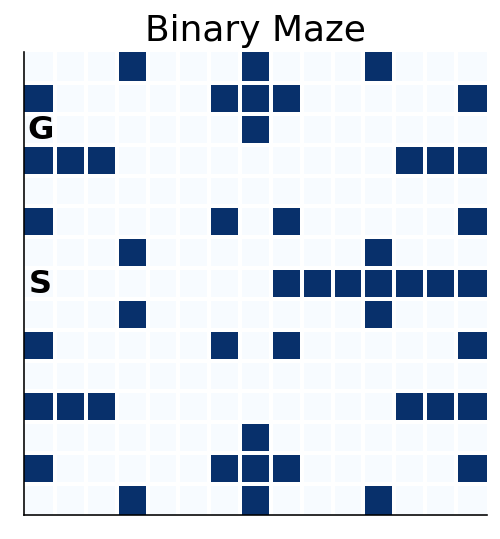

In [15]:
# Visualise MazeWorld

# Maze parameters
tasks_specifications = { "max_level":6, "goal_state":None, "discount":0.9,
          "penalty_for_walls":-5, "observation_type":ObservationType.GRID,
          "max_episode_length":200  }

# Instantiate
simple_grid = MazeWorld(**tasks_specifications)

# Plot them
simple_grid.plot_grid()
plt.title('Binary Maze')

Text(0.5, 1.0, 'Obstacle')

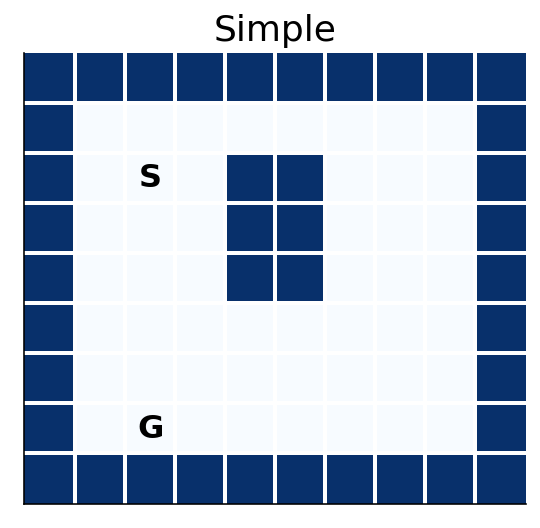

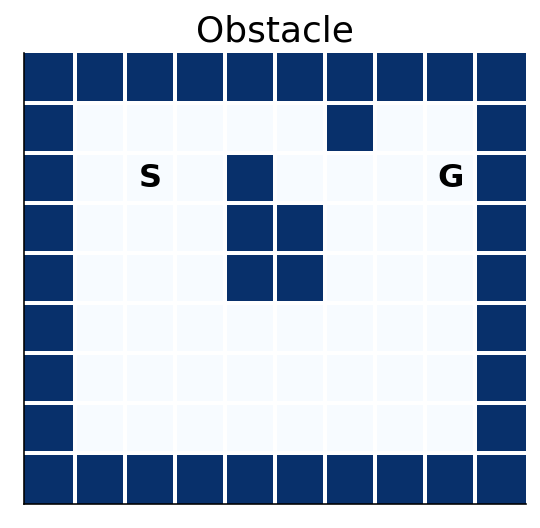

In [14]:
# # Visualise GridWorlds

# # Instantiate two tabular environments, a simple task, and one that involves
# # the avoidance of an obstacle.
# simple_grid = build_gridworld_task(
#     task='simple', observation_type=ObservationType.GRID)
# obstacle_grid = build_gridworld_task(
#     task='obstacle', observation_type=ObservationType.GRID)

# # Plot them.
# simple_grid.plot_grid()
# plt.title('Simple')

# obstacle_grid.plot_grid()
# plt.title('Obstacle')

In this environment, the agent has four possible  <font color='blue'>**actions**</font>: `up`, `right`, `down`, and `left`.  The <font color='green'>**reward**</font> is `-5` for bumping into a wall, `+10` for reaching the goal, and `0` otherwise. The episode ends when the agent reaches the goal, and otherwise continues. The **discount** on continuing steps, is $\gamma = 0.9$. 

Before we start building an agent to interact with this environment, let's first look at the types of objects the environment either returns (e.g., <font color='redorange'>**observations**</font>) or consumes (e.g., <font color='blue'>**actions**</font>). The `environment_spec` will show you the form of the <font color='redorange'>**observations**</font>, <font color='green'>**rewards**</font> and **discounts** that the environment exposes and the form of the <font color='blue'>**actions**</font> that can be taken.


In [188]:
# @title Look at environment_spec { form-width: "30%" }

# Note: setup_environment is implemented in the same cell as GridWorld.
environment, environment_spec = setup_environment(simple_grid)

print('actions:\n', environment_spec.actions, '\n')
print('observations:\n', environment_spec.observations, '\n')
print('rewards:\n', environment_spec.rewards, '\n')
print('discounts:\n', environment_spec.discounts, '\n')

actions:
 DiscreteArray(shape=(), dtype=int32, name=action, minimum=0, maximum=3, num_values=4) 

observations:
 Array(shape=(15, 15, 3), dtype=dtype('float32'), name='observation_grid') 

rewards:
 Array(shape=(), dtype=dtype('float32'), name='reward') 

discounts:
 BoundedArray(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0) 




We first set the environment to its initial state by calling the `reset()` method which returns the first observation and resets the agent to the starting location.


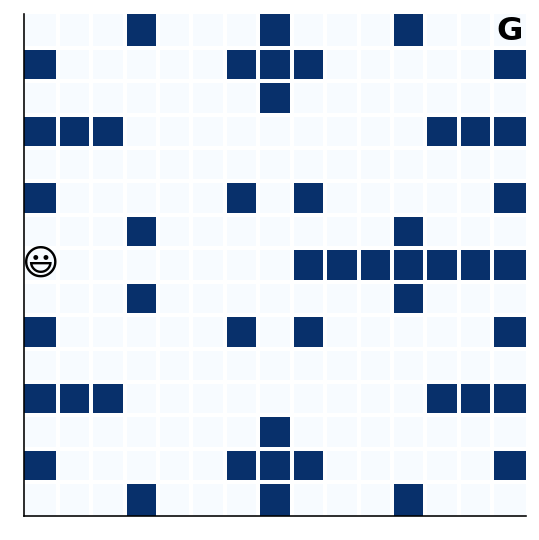

In [189]:
environment.reset()
environment.plot_state()

Now we want to take an action to interact with the environment. We do this by passing a valid action to the `dm_env.Environment.step()` method which returns a `dm_env.TimeStep` namedtuple with fields `(step_type, reward, discount, observation)`.

Let's take an action and visualise the resulting state of the grid-world. (You'll need to rerun the cell if you pick a new action.)

STEP START: (8, 7), 1j
STEP CHANGE: 0, -1, (-1+0j)
Illegal
STEP END: (8, 7), 1j


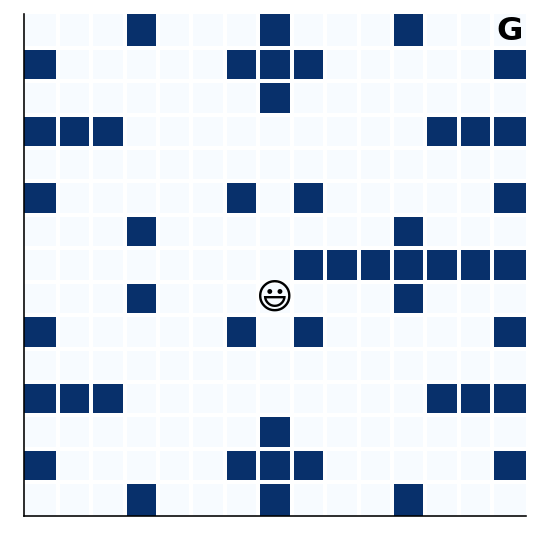

In [203]:
# @title Pick an action and see the state changing
action = "right" #@param ["up", "right", "down", "left"] {type:"string"}

action_int = {'up': 0,
              'right': 1,
              'down': 2,
              'left':3 }
action = int(action_int[action])
timestep = environment.step(action)  # pytype: dm_env.TimeStep
environment.plot_state()

## Define loops, evaluation


In [18]:
# @title Run loop  { form-width: "30%" }
# @markdown This function runs an agent in the environment for a number of
# @markdown episodes, allowing it to learn.

# @markdown *Double-click* to inspect the `run_loop` function.


def run_loop(environment,
             agent,
             num_episodes=None,
             num_steps=None,
             logger_time_delta=1.,
             label='training_loop',
             log_loss=False,
             ):
  """Perform the run loop.

  We are following the Acme run loop.

  Run the environment loop for `num_episodes` episodes. Each episode is itself
  a loop which interacts first with the environment to get an observation and
  then give that observation to the agent in order to retrieve an action. Upon
  termination of an episode a new episode will be started. If the number of
  episodes is not given then this will interact with the environment
  infinitely.

  Args:
    environment: dm_env used to generate trajectories.
    agent: acme.Actor for selecting actions in the run loop.
    num_steps: number of steps to run the loop for. If `None` (default), runs
      without limit.
    num_episodes: number of episodes to run the loop for. If `None` (default),
      runs without limit.
    logger_time_delta: time interval (in seconds) between consecutive logging
      steps.
    label: optional label used at logging steps.
  """
  logger = loggers.TerminalLogger(label=label, time_delta=logger_time_delta)
  iterator = range(num_episodes) if num_episodes else itertools.count()
  all_returns = []

  num_total_steps = 0
  for episode in iterator:
    # Reset any counts and start the environment.
    start_time = time.time()
    episode_steps = 0
    episode_return = 0
    episode_loss = 0

    timestep = environment.reset()

    # Make the first observation.
    agent.observe_first(timestep)

    # Run an episode.
    while not timestep.last():
      # Generate an action from the agent's policy and step the environment.
      action = agent.select_action(timestep.observation)
      timestep = environment.step(action)

      # Have the agent observe the timestep and let the agent update itself.
      agent.observe(action, next_timestep=timestep)
      agent.update()

      # Book-keeping.
      episode_steps += 1
      num_total_steps += 1
      episode_return += timestep.reward

      if log_loss:
        episode_loss += agent.last_loss

      if num_steps is not None and num_total_steps >= num_steps:
        break

    # Collect the results and combine with counts.
    steps_per_second = episode_steps / (time.time() - start_time)
    result = {
        'episode': episode,
        'episode_length': episode_steps,
        'episode_return': episode_return,
    }
    if log_loss:
      result['loss_avg'] = episode_loss/episode_steps

    all_returns.append(episode_return)

    # Log the given results.
    logger.write(result)

    if num_steps is not None and num_total_steps >= num_steps:
      break
  return all_returns

In [19]:
# @title Implement the evaluation loop { form-width: "30%" }
# @markdown This function runs the agent in the environment for a number of
# @markdown episodes, without allowing it to learn, in order to evaluate it.

# @markdown *Double-click* to inspect the `evaluate` function.

def evaluate(environment: dm_env.Environment,
             agent: acme.Actor,
             evaluation_episodes: int):
  frames = []

  for episode in range(evaluation_episodes):
    timestep = environment.reset()
    episode_return = 0
    steps = 0
    while not timestep.last():
      frames.append(environment.plot_state(return_rgb=True))

      action = agent.select_action(timestep.observation)
      timestep = environment.step(action)
      steps += 1
      episode_return += timestep.reward
    print(
        f'Episode {episode} ended with reward {episode_return} in {steps} steps'
    )
  return frames

def display_video(frames: Sequence[np.ndarray],
                  filename: str = 'temp.mp4',
                  frame_rate: int = 12):
  """Save and display video."""
  # Write the frames to a video.
  with imageio.get_writer(filename, fps=frame_rate) as video:
    for frame in frames:
      video.append_data(frame)

  # Read video and display the video.
  video = open(filename, 'rb').read()
  b64_video = base64.b64encode(video)
  video_tag = ('<video  width="320" height="240" controls alt="test" '
               'src="data:video/mp4;base64,{0}">').format(b64_video.decode())
  return IPython.display.HTML(video_tag)

## Code random, SARSA, policy eval agents

## Random Agent

Below is a partially complete implemention of an agent that follows a random (non-learning) policy. Fill in the ```select_action``` method.

The ```select_action``` method should return a random **integer** between 0 and ```self._num_actions``` (not a tensor or an array!)

In [20]:
class RandomAgent(acme.Actor):

  def __init__(self, environment_spec):
    """Gets the number of available actions from the environment spec."""
    self._num_actions = environment_spec.actions.num_values

  def select_action(self, observation):
    """Selects an action uniformly at random."""
    #################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your implementation
    raise NotImplementedError("Student exercise: complete the select action method")
    #################################################
    # TODO return a random integer beween 0 and self._num_actions.
    # HINT: see the reference for how to sample a random integer in numpy:
    #   https://numpy.org/doc/1.16/reference/routines.random.html
    action = np.random.randint(self._num_actions)
    return action

  def observe_first(self, timestep):
    """Does not record as the RandomAgent has no use for data."""
    pass

  def observe(self, action, next_timestep):
    """Does not record as the RandomAgent has no use for data."""
    pass

  def update(self):
    """Does not update as the RandomAgent does not learn from data."""
    pass


In [21]:
# @title Visualisation of a random agent in GridWorld { form-width: "30%" }

# Create the agent by giving it the action space specification.
agent = RandomAgent(environment_spec)

# Run the agent in the evaluation loop, which returns the frames.
frames = evaluate(environment, agent, evaluation_episodes=1)

# Visualize the random agent's episode.
display_video(frames)

NotImplementedError: ignored

## Policy Evaluation Agent


Tabular agents implement a function `q_values()` returning a matrix of Q values
of shape: (`number_of_states`, `number_of_actions`)

In this section, we will implement a `PolicyEvalAgent` as an ACME actor: given an `evaluation_policy` $\pi_e$ and a `behaviour_policy` $\pi_b$, it will use the `behaviour_policy` to choose actions, and it will use the corresponding trajectory data to evaluate the `evaluation_policy` (i.e. compute the Q-values as if you were following the `evaluation_policy`). 

Algorithm:

**Initialize** $Q(\color{red}{s}, \color{blue}{a})$ for all $\color{red}{s}$ ∈ $\mathcal{\color{red}S}$ and $\color{blue}a$ ∈ $\mathcal{\color{blue}A}(\color{red}s)$

**Loop forever**:

1. $\color{red}{s} \gets{}$current (nonterminal) state
 
2. $\color{blue}{a} \gets{} \text{behaviour_policy }\pi_b(\color{red}s)$
 
3. Take action $\color{blue}{a}$; observe resulting reward $\color{green}{r}$, discount $\gamma$, and state, $\color{red}{s'}$

4. Compute TD-error: $\delta = \color{green}R + \gamma Q(\color{red}{s'}, \underbrace{\pi_e(\color{red}{s'}}_{\color{blue}{a'}})) − Q(\color{red}s, \color{blue}a)$

4. Update Q-value with a small $\alpha$ step: $Q(\color{red}s, \color{blue}a) \gets Q(\color{red}s, \color{blue}a) + \alpha \delta$


We will use a uniform `random policy` as our `evaluation policy` here, but you could replace this with any policy you want, such as a greedy one.

In [ ]:
# Uniform random policy
def random_policy(q):
  return np.random.randint(4)

In [ ]:
class PolicyEvalAgent(acme.Actor):

  def __init__(self, environment_spec, evaluated_policy,
               behaviour_policy=random_policy, step_size=0.1):

    self._state = None
    # Get number of states and actions from the environment spec.
    self._number_of_states = environment_spec.observations.num_values
    self._number_of_actions = environment_spec.actions.num_values
    self._step_size = step_size
    self._behaviour_policy = behaviour_policy
    self._evaluated_policy = evaluated_policy
    #################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your implementation
    # raise NotImplementedError("Initialize your Q-values!")
    #################################################
    # TODO Initialize the Q-values to be all zeros.
    # (Note: can also be random, but we use zeros here for reproducibility)
    # HINT: This is a table of state and action pairs, so needs to be a 2-D
    #   array. See the reference for how to create this in numpy:
    #   https://numpy.org/doc/stable/reference/generated/numpy.zeros.html
    self._q = np.zeros((self._number_of_states, self._number_of_actions))
    self._action = None
    self._next_state = None

  @property
  def q_values(self):
    # return the Q values
    return self._q

  def select_action(self, observation):
    # Select an action
    return self._behaviour_policy(self._q[observation])

  def observe_first(self, timestep):
    self._state = timestep.observation

  def observe(self, action, next_timestep):
    s = self._state
    a = action
    r = next_timestep.reward
    g = next_timestep.discount
    next_s = next_timestep.observation

    # Compute TD-Error.
    self._action = a
    self._next_state = next_s
    #################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your implementation
    # raise NotImplementedError("Need to select the next action")
    #################################################
    # TODO Select the next action from the evaluation policy
    # HINT: Refer to step 4 of the algorithm above.
    next_a = self._evaluated_policy(self._q[next_s])
    self._td_error = r + g * self._q[next_s, next_a] - self._q[s, a]

  def update(self):
    # Updates
    s = self._state
    a = self._action
    # Q-value table update.
    self._q[s, a] += self._step_size * self._td_error
    # Update the state
    self._state = self._next_state


In [ ]:
# @title Perform policy evaluation { form-width: "30%" }
# @markdown Here you can visualize the state value and action-value functions for the "simple" task.
num_steps = 1e3

# Create the environment
grid = build_gridworld_task(task='simple')
environment, environment_spec = setup_environment(grid)

# Create the policy evaluation agent to evaluate a random policy.
agent = PolicyEvalAgent(environment_spec, evaluated_policy=random_policy)

# run experiment and get the value functions from agent
returns = run_loop(environment=environment, agent=agent, num_steps=int(num_steps))

# get the q-values
q = agent.q_values.reshape(grid._layout.shape + (4, ))

# visualize value functions
print('AFTER {} STEPS ...'.format(num_steps))
plot_action_values(q, epsilon=1.)

## SARSA Agent
In this section, we are focusing on control RL algorithms, which perform the **evaluation** and **improvement** of the policy synchronously. That is, the policy that is being evaluated improves as the agent is using it to interact with the environent.


The first algorithm we are going to be looking at is SARSA. This is an **on-policy algorithm** -- i.e: the data collection is done by leveraging the policy we're trying to optimize. 

As discussed during lectures, a greedy policy with respect to a given $\color{Green}Q$ fails to explore the environment as needed; we will use instead an $\epsilon$-greedy policy with respect to $\color{Green}Q$.

### SARSA Algorithm

**Input:**
- $\epsilon \in (0, 1)$ the probability of taking a random action , and
- $\alpha > 0$ the step size, also known as learning rate.

**Initialize:** $\color{green}Q(\color{red}{s}, \color{blue}{a})$ for all $\color{red}{s}$ ∈ $\mathcal{\color{red}S}$ and $\color{blue}a$ ∈ $\mathcal{\color{blue}A}$

**Loop forever:**

1. Get $\color{red}s \gets{}$current (non-terminal) state
 
2. Select $\color{blue}a \gets{} \text{epsilon_greedy}(\color{green}Q(\color{red}s, \cdot))$
 
3. Step in the environment by passing the selected action $\color{blue}a$

4. Observe resulting reward $\color{green}r$, discount $\gamma$, and state $\color{red}{s'}$

5. Compute TD error: $\Delta \color{green}Q \gets 
\color{green}r + \gamma \color{green}Q(\color{red}{s'}, \color{blue}{a'}) − \color{green}Q(\color{red}s, \color{blue}a)$, <br> where $\color{blue}{a'} \gets \text{epsilon_greedy}(\color{green}Q(\color{red}{s'}, \cdot))$

5. Update $\color{green}Q(\color{red}s, \color{blue}a) \gets \color{green}Q(\color{red}s, \color{blue}a) + \alpha \Delta \color{green}Q$


### Coding Exercise 5.1: Implement $\epsilon$-greedy
Below you will find incomplete code for sampling from an $\epsilon$-greedy policy, to be used later when we implement an agent that learns values according to the SARSA algorithm.




In [ ]:
def epsilon_greedy(
    q_values_at_s: np.ndarray,  # Q-values in state s: Q(s, a).
    epsilon: float = 0.1  # Probability of taking a random action.
    ):
  """Return an epsilon-greedy action sample."""
  #################################################
  # Fill in missing code below (...),
  # then remove or comment the line below to test your implementation
  # raise NotImplementedError("Student exercise: complete epsilon greedy policy function")
  #################################################
  # TODO generate a uniform random number and compare it to epsilon to decide if
  # the action should be greedy or not
  # HINT: Use np.random.random() to generate a random float from 0 to 1.
  if np.random.random() > epsilon:
    #TODO Greedy: Pick action with the largest Q-value.
    action = np.argmax(q_values_at_s)
  else:
    # Get the number of actions from the size of the given vector of Q-values.
    num_actions = np.array(q_values_at_s).shape[-1]
    # TODO else return a random action
    # HINT: Use np.random.randint() to generate a random integer.
    action = np.random.randint(len(q_values_at_s))

  return action


In [ ]:
# @title Sample action from $\epsilon$-greedy { form-width: "30%" }
# @markdown With $\epsilon=0.5$, you should see that about half the time, you will get back the optimal
# @markdown action 3, but half the time, it will be random.

# Create fake q-values
q_values = np.array([0, 0, 0, 1])

# Set epsilon = 0.5
epsilon = 0.5
action = epsilon_greedy(q_values, epsilon=epsilon)
print(action)

### Coding Exercise 5.2: Run your SARSA agent on the `obstacle` environment

This environment is similar to the Cliff-walking example from [Sutton & Barto](http://incompleteideas.net/book/RLbook2018.pdf) and allows us to see the different policies learned by on-policy vs off-policy methods. Try varying the number of steps.

In [ ]:
class SarsaAgent(acme.Actor):

  def __init__(self,
               environment_spec: specs.EnvironmentSpec,
               epsilon: float,
               step_size: float = 0.1
               ):

    # Get number of states and actions from the environment spec.
    self._num_states = environment_spec.observations.num_values
    self._num_actions = environment_spec.actions.num_values

    # Create the table of Q-values, all initialized at zero.
    self._q = np.zeros((self._num_states, self._num_actions))

    # Store algorithm hyper-parameters.
    self._step_size = step_size
    self._epsilon = epsilon

    # Containers you may find useful.
    self._state = None
    self._action = None
    self._next_state = None

  @property
  def q_values(self):
    return self._q

  def select_action(self, observation):
    return epsilon_greedy(self._q[observation], self._epsilon)

  def observe_first(self, timestep):
    # Set current state.
    self._state = timestep.observation

  def observe(self, action, next_timestep):
    # Unpacking the timestep to lighten notation.
    s = self._state
    a = action
    r = next_timestep.reward
    g = next_timestep.discount
    next_s = next_timestep.observation
    # Compute the action that would be taken from the next state.
    next_a = self.select_action(next_s)
    # Compute the on-policy Q-value update.
    self._action = a
    self._next_state = next_s
    #################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your implementation
    # raise NotImplementedError("Student exercise: complete the on-policy Q-value update")
    #################################################
    # TODO complete the line below to compute the temporal difference error
    # HINT: see step 5 in the pseudocode above.
    self._td_error = r + g * self._q[next_s, next_a] - self._q[s, a]

  def update(self):
    # Optional unpacking to lighten notation.
    s = self._state
    a = self._action
    #################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your implementation
    # raise NotImplementedError("Student exercise: complete value update")
    #################################################
    # Update the Q-value table value at (s, a).
    # TODO: Update the Q-value table value at (s, a).
    # HINT: see step 6 in the pseudocode above, remember that alpha = step_size!
    self._q[s, a] += self._step_size * self._td_error
    # Update the current state.
    self._state = self._next_state


In [ ]:
# @title Run SARSA agent and visualize value function

num_steps = 1e5  # @param {type:"number"}
num_steps = int(num_steps)

# Create the environment.
grid = build_gridworld_task(task='obstacle')
environment, environment_spec = setup_environment(grid)

# Create the agent.
agent = SarsaAgent(environment_spec, epsilon=0.1, step_size=0.1)

# Run the experiment and get the value functions from agent
returns = run_loop(environment=environment, agent=agent, num_steps=num_steps)
print('AFTER {0:,} STEPS ...'.format(num_steps))

# Get the Q-values and reshape them to recover grid-like structure of states.
q_values = agent.q_values
grid_shape = grid.layout.shape
q_values = q_values.reshape([*grid_shape, -1])

# Visualize the value and Q-value tables.
plot_action_values(q_values, epsilon=1.)

# Visualize the greedy policy.
environment.plot_greedy_policy(q_values)


### Section 5.2 Off-policy control: Q-learning Agent
Reminder:  Q - learning is a very powerful and general algorithm, that enables control(figuring out the optimal policy/value function) both on and off-policy.

Initialize  Q(s, a) for all  s∈S and a∈A

Loop forever:

Get  s← current(non-terminal) state

Select  a←behaviour_policy(s)

Step in the environment by passing the selected action  a

Observe resulting reward  r, discount  γ, and state,  s′

Compute the TD error:  ΔQ←r+γQ(s′, a′)−Q(s, a),
where  a′←argmaxAQ(s′, ⋅)

Update  Q(s, a)←Q(s, a)+αΔQ

Notice that the actions  a and a′  are not selected using the same policy, hence this algorithm being off-policy.


In [ ]:
QValues = np.ndarray
Action = int
# A value-based policy takes the Q-values at a state and returns an action.
ValueBasedPolicy = Callable[[QValues], Action]


class QLearningAgent(acme.Actor):

  def __init__(self,
               environment_spec: specs.EnvironmentSpec,
               behaviour_policy: ValueBasedPolicy,
               step_size: float = 0.1):

    # Get number of states and actions from the environment spec.
    self._num_states = environment_spec.observations.num_values
    self._num_actions = environment_spec.actions.num_values

    # Create the table of Q-values, all initialized at zero.
    self._q = np.zeros((self._num_states, self._num_actions))

    # Store algorithm hyper-parameters.
    self._step_size = step_size

    # Store behavior policy.
    self._behaviour_policy = behaviour_policy

    # Containers you may find useful.
    self._state = None
    self._action = None
    self._next_state = None

  @property
  def q_values(self):
    return self._q

  def select_action(self, observation):
    return self._behaviour_policy(self._q[observation])

  def observe_first(self, timestep):
    # Set current state.
    self._state = timestep.observation

  def observe(self, action, next_timestep):
    # Unpacking the timestep to lighten notation.
    s = self._state
    a = action
    r = next_timestep.reward
    g = next_timestep.discount
    next_s = next_timestep.observation

    # Compute the TD error.
    self._action = a
    self._next_state = next_s
    #################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your implementation
    # raise NotImplementedError("Student exercise: complete the off-policy Q-value update")
    #################################################
    # TODO complete the line below to compute the temporal difference error
    # HINT: This is very similar to what we did for SARSA, except keep in mind
    # that we're now taking a max over the q-values (see lecture footnotes above).
    # You will find the function np.max() useful.
    self._td_error = r + g * self._q[next_s,
                                     np.argmax(self._q[next_s])] - self._q[s, a]

  def update(self):
    # Optional unpacking to lighten notation.
    s = self._state
    a = self._action
    #################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your implementation
    # raise NotImplementedError("Student exercise: complete value update")
    #################################################
    # Update the Q-value table value at (s, a).
    # TODO: Update the Q-value table value at (s, a).
    # HINT: see step 6 in the pseudocode above, remember that alpha = step_size!
    self._q[s, a] += self._step_size * self._td_error
    # Update the current state.
    self._state = self._next_state

In [ ]:
# @title Run your Q-learning
epsilon = 0.95  # @param {type:"number"}
num_steps = 1e4  # @param {type:"number"}
num_steps = int(num_steps)

# environment
grid = build_gridworld_task(task='obstacle')
environment, environment_spec = setup_environment(grid)

# behavior policy


def behavior_policy(qval): return epsilon_greedy(qval, epsilon=epsilon)


# agent
agent = QLearningAgent(environment_spec, behavior_policy, step_size=0.1)

# run experiment and get the value functions from agent
returns = run_loop(environment=environment, agent=agent, num_steps=num_steps)

# get the q-values
q = agent.q_values.reshape(grid.layout.shape + (4,))

# visualize value functions
print('AFTER {:,} STEPS ...'.format(num_steps))
plot_action_values(q, epsilon=0)

# visualise the greedy policy
grid.plot_greedy_policy(q)
plt.show()


## Replay buffers

In [ ]:
# Simple replay buffer

# Create a convenient container for the SARS tuples required by deep RL agents.
Transitions = collections.namedtuple(
    'Transitions', ['state', 'action', 'reward', 'discount', 'next_state'])


class ReplayBuffer(object):
  """A simple Python replay buffer."""

  def __init__(self, capacity: int = None):
    self.buffer = collections.deque(maxlen=capacity)
    self._prev_state = None

  def add_first(self, initial_timestep: dm_env.TimeStep):
    self._prev_state = initial_timestep.observation

  def add(self, action: int, timestep: dm_env.TimeStep):
    transition = Transitions(
        state=self._prev_state,
        action=action,
        reward=timestep.reward,
        discount=timestep.discount,
        next_state=timestep.observation,
    )
    self.buffer.append(transition)
    self._prev_state = timestep.observation

  def sample(self, batch_size: int) -> Transitions:
    # Sample a random batch of Transitions as a list.
    batch_as_list = random.sample(self.buffer, batch_size)

    # Convert the list of `batch_size` Transitions into a single Transitions
    # object where each field has `batch_size` stacked fields.
    return tree_utils.stack_sequence_fields(batch_as_list)

  def flush(self) -> Transitions:
    entire_buffer = tree_utils.stack_sequence_fields(self.buffer)
    self.buffer.clear()
    return entire_buffer

  def is_ready(self, batch_size: int) -> bool:
    return batch_size <= len(self.buffer)


## Neural fitted Q-learning

# Create a convenient container for the SARS tuples required by NFQ.
Transitions = collections.namedtuple(
    'Transitions', ['state', 'action', 'reward', 'discount', 'next_state'])


class NeuralFittedQAgent(acme.Actor):

  def __init__(self,
               environment_spec: specs.EnvironmentSpec,
               q_network: nn.Module,
               replay_capacity: int = 100_000,
               epsilon: float = 0.1,
               batch_size: int = 1,
               learning_rate: float = 3e-4):

    # Store agent hyperparameters and network.
    self._num_actions = environment_spec.actions.num_values
    self._epsilon = epsilon
    self._batch_size = batch_size
    self._q_network = q_network

    # Container for the computed loss (see run_loop implementation above).
    self.last_loss = 0.0

    # Create the replay buffer.
    self._replay_buffer = ReplayBuffer(replay_capacity)

    # Setup optimizer that will train the network to minimize the loss.
    self._optimizer = torch.optim.Adam(self._q_network.parameters(),lr = learning_rate)
    self._loss_fn = nn.MSELoss()

  def select_action(self, observation):
    # Compute Q-values.
    q_values = self._q_network(torch.tensor(observation).unsqueeze(0))  # Adds batch dimension.
    q_values = q_values.squeeze(0)   # Removes batch dimension

    # Select epsilon-greedy action.
    if self._epsilon < torch.rand(1):
      action = q_values.argmax(axis=-1)
    else:
      action = torch.randint(low=0, high=self._num_actions , size=(1,), dtype=torch.int64)
    return action

  def q_values(self, observation):
    q_values = self._q_network(torch.tensor(observation).unsqueeze(0))
    return q_values.squeeze(0).detach()

  def update(self):

    if not self._replay_buffer.is_ready(self._batch_size):
      # If the replay buffer is not ready to sample from, do nothing.
      return

    # Sample a minibatch of transitions from experience replay.
    transitions = self._replay_buffer.sample(self._batch_size)

    # Note: each of these tensors will be of shape [batch_size, ...].
    s = torch.tensor(transitions.state)
    a = torch.tensor(transitions.action,dtype=torch.int64)
    r = torch.tensor(transitions.reward)
    d = torch.tensor(transitions.discount)
    next_s = torch.tensor(transitions.next_state)

    # Compute the Q-values at next states in the transitions.
    with torch.no_grad():
      q_next_s = self._q_network(next_s)  # Shape [batch_size, num_actions].
      max_q_next_s = q_next_s.max(axis=-1)[0]
      # Compute the TD error and then the losses.
      target_q_value = r + d * max_q_next_s

    # Compute the Q-values at original state.
    q_s = self._q_network(s)

    # Gather the Q-value corresponding to each action in the batch.
    q_s_a = q_s.gather(1, a.view(-1,1)).squeeze(0)
    #################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your implementation
    # raise NotImplementedError("Student exercise: complete the NFQ Agent")
    #################################################
    # TODO Average the squared TD errors over the entire batch using
    # self._loss_fn, which is defined above as nn.MSELoss()
    # HINT: Take a look at the reference for nn.MSELoss here:
    #  https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html
    #  What should you put for the input and the target?
    loss = self._loss_fn(target_q_value, q_s_a)
    

    # Compute the gradients of the loss with respect to the q_network variables.
    self._optimizer.zero_grad()

    loss.backward()
    # Apply the gradient update.
    self._optimizer.step()

    # Store the loss for logging purposes (see run_loop implementation above).
    self.last_loss = loss.detach().numpy()

  def observe_first(self, timestep: dm_env.TimeStep):
    self._replay_buffer.add_first(timestep)

  def observe(self, action: int, next_timestep: dm_env.TimeStep):
    self._replay_buffer.add(action, next_timestep)

In [ ]:
# @title Training the NFQ Agent
epsilon = 0.4  # @param {type:"number"}

max_episode_length = 1000

# Create the environment.
grid = build_gridworld_task(
    task='simple',
    observation_type=ObservationType.AGENT_GOAL_POS,
    max_episode_length=max_episode_length)
environment, environment_spec = setup_environment(grid)

# Define the neural function approximator (aka Q network).
q_network = nn.Sequential(nn.Linear(4, 50),
                          nn.ReLU(),
                          nn.Linear(50, 50),
                          nn.ReLU(),
                          nn.Linear(50, environment_spec.actions.num_values))
# Build the trainable Q-learning agent
agent = NeuralFittedQAgent(
    environment_spec,
    q_network,
    epsilon=epsilon,
    replay_capacity=100_000,
    batch_size=10,
    learning_rate=1e-3)

returns = run_loop(
    environment=environment,
    agent=agent,
    num_episodes=500,
    logger_time_delta=1.,
    log_loss=True)

In [ ]:
# @title Evaluating the agent (set $\epsilon=0$)
# Temporarily change epsilon to be more greedy; remember to change it back.
agent._epsilon = 0.5

# Record a few episodes.
frames = evaluate(environment, agent, evaluation_episodes=5)

# Change epsilon back.
agent._epsilon = epsilon

# Display the video of the episodes.
display_video(frames, frame_rate=6)

In [ ]:
# @title Visualise the learned $Q$ values

# Evaluate the policy for every state, similar to tabular agents above.

environment.reset()
pi = np.zeros(grid._layout_dims, dtype=np.int32)
q = np.zeros(grid._layout_dims + (4, ))
for y in range(grid._layout_dims[0]):
  for x in range(grid._layout_dims[1]):
    # Hack observation to see what the Q-network would output at that point.
    environment.set_state(x, y)
    obs = environment.get_obs()
    q[y, x] = np.asarray(agent.q_values(obs))
    pi[y, x] = np.asarray(agent.select_action(obs))

plot_action_values(q)

## Deep Q-Networks

In [ ]:
class DQN(acme.Actor):

  def __init__(self,
               environment_spec: specs.EnvironmentSpec,
               network: nn.Module,
               replay_capacity: int = 100_000,
               epsilon: float = 0.1,
               batch_size: int = 1,
               learning_rate: float = 5e-4,
               target_update_frequency: int = 10):

    # Store agent hyperparameters and network.
    self._num_actions = environment_spec.actions.num_values
    self._epsilon = epsilon
    self._batch_size = batch_size
    self._q_network = q_network

    # create a second q net with the same structure and initial values, which
    # we'll be updating separately from the learned q-network.
    self._target_network = copy.deepcopy(self._q_network)

    # Container for the computed loss (see run_loop implementation above).
    self.last_loss = 0.0

    # Create the replay buffer.
    self._replay_buffer = ReplayBuffer(replay_capacity)
    # Keep an internal tracker of steps
    self._current_step = 0

    # How often to update the target network
    self._target_update_frequency = target_update_frequency
    # Setup optimizer that will train the network to minimize the loss.
    self._optimizer = torch.optim.Adam(
        self._q_network.parameters(), lr=learning_rate)
    self._loss_fn = nn.MSELoss()

  def select_action(self, observation):
    # Compute Q-values.
    # Sonnet requires a batch dimension, which we squeeze out right after.
    # Adds batch dimension.
    q_values = self._q_network(torch.tensor(observation).unsqueeze(0))
    q_values = q_values.squeeze(0)   # Removes batch dimension

    # Select epsilon-greedy action.
    if self._epsilon < torch.rand(1):
      action = q_values.argmax(axis=-1)
    else:
      action = torch.randint(low=0, high=self._num_actions,
                             size=(1,), dtype=torch.int64)
    return action

  def q_values(self, observation):
    q_values = self._q_network(torch.tensor(observation).unsqueeze(0))
    return q_values.squeeze(0).detach()

  def update(self):
    self._current_step += 1

    if not self._replay_buffer.is_ready(self._batch_size):
      # If the replay buffer is not ready to sample from, do nothing.
      return

    # Sample a minibatch of transitions from experience replay.
    transitions = self._replay_buffer.sample(self._batch_size)

    # Optionally unpack the transitions to lighten notation.
    # Note: each of these tensors will be of shape [batch_size, ...].
    s = torch.tensor(transitions.state)
    a = torch.tensor(transitions.action, dtype=torch.int64)
    r = torch.tensor(transitions.reward)
    d = torch.tensor(transitions.discount)
    next_s = torch.tensor(transitions.next_state)

    # Compute the Q-values at next states in the transitions.
    with torch.no_grad():
      #################################################
      # Fill in missing code below (...),
      # then remove or comment the line below to test your implementation
      # raise NotImplementedError("Student exercise: complete the DQN Agent")
      #################################################
      #TODO get the value of the next states evaluated by the target network
      #HINT: use self._target_network, defined above.
      # Shape [batch_size, num_actions].
      q_next_s = self._target_network(next_s)
      max_q_next_s = q_next_s.max(axis=-1)[0]
      # Compute the TD error and then the losses.
      target_q_value = r + d * max_q_next_s

    # Compute the Q-values at original state.
    q_s = self._q_network(s)

    # Gather the Q-value corresponding to each action in the batch.
    q_s_a = q_s.gather(1, a.view(-1, 1)).squeeze(0)

    # Average the squared TD errors over the entire batch
    loss = self._loss_fn(target_q_value, q_s_a)

    # Compute the gradients of the loss with respect to the q_network variables.
    self._optimizer.zero_grad()

    loss.backward()
    # Apply the gradient update.
    self._optimizer.step()

    if self._current_step % self._target_update_frequency == 0:
      self._target_network.load_state_dict(self._q_network.state_dict())
    # Store the loss for logging purposes (see run_loop implementation above).
    self.last_loss = loss.detach().numpy()

  def observe_first(self, timestep: dm_env.TimeStep):
    self._replay_buffer.add_first(timestep)

  def observe(self, action: int, next_timestep: dm_env.TimeStep):
    self._replay_buffer.add(action, next_timestep)


# Create a convenient container for the SARS tuples required by NFQ.
Transitions = collections.namedtuple(
    'Transitions', ['state', 'action', 'reward', 'discount', 'next_state'])

In [ ]:
# @title Train and evaluate the DQN agent

epsilon = 0.25  # @param {type: "number"}
num_episodes = 5000  # @param {type: "integer"}
max_episode_length = 50  # @param {type: "integer"}

grid = build_gridworld_task(
    task='simple',
    observation_type=ObservationType.GRID,
    max_episode_length=max_episode_length)
environment, environment_spec = setup_environment(grid)

# Build the agent's network.


class Permute(nn.Module):
  def __init__(self, order: list):
    super(Permute, self).__init__()
    self.order = order

  def forward(self, x):
    return x.permute(self.order)


q_network = nn.Sequential(Permute([0, 3, 1, 2]),
                          nn.Conv2d(3, 32, kernel_size=4,
                                    stride=2, padding=1),
                          nn.ReLU(),
                          nn.Conv2d(32, 64, kernel_size=3,
                                    stride=1, padding=1),
                          nn.ReLU(),
                          nn.MaxPool2d(3, 1),
                          nn.Flatten(),
                          nn.Linear(384, 50),
                          nn.ReLU(),
                          nn.Linear(50, environment_spec.actions.num_values)
                          )

agent = DQN(
    environment_spec=environment_spec,
    network=q_network,
    batch_size=10,
    epsilon=epsilon,
    target_update_frequency=25)

returns = run_loop(
    environment=environment,
    agent=agent,
    num_episodes=num_episodes,
    num_steps=100000)


In [ ]:
# @title Compare the greedy policy with the agent's policy

environment.plot_greedy_policy(q)
plt.figtext(-.08, .95, "Greedy policy using the learnt Q-values")
plt.title('')
plt.show()

environment.plot_policy(pi)
plt.figtext(-.08, .95, "Policy using the agent's epsilon-greedy policy")
plt.title('')
plt.show()